# Component 4: FAISS Library Benchmark

## About FAISS

**FAISS (Facebook AI Similarity Search)** is a library developed by Meta AI Research for efficient similarity search and clustering of dense vectors. It's designed for billion-scale datasets and is widely used in production systems.



In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import faiss

np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)

In [2]:
doc_vectors = np.load("Data/processed/doc_vectors_w2v.npy").astype('float32')
metadata = pd.read_csv("Data/processed/doc_metadata.csv")

print(f"Vectors: {doc_vectors.shape}")
print(f"Metadata: {metadata.shape[0]} records")
print(f"FAISS version: {faiss.__version__}")

Vectors: (17830, 200)
Metadata: 17830 records
FAISS version: 1.13.0


## Helper Functions

In [3]:
def compute_ndcg_at_k(predicted, actual, k):
    """Normalized Discounted Cumulative Gain."""
    dcg = sum([1/np.log2(i+2) for i, doc in enumerate(predicted[:k]) if doc in actual[:k]])
    idcg = sum([1/np.log2(i+2) for i in range(min(len(actual), k))])
    return dcg / idcg if idcg > 0 else 0

def compute_recall_at_k(predicted, actual, k):
    """Recall@k."""
    return len(set(predicted[:k]) & set(actual[:k])) / k

def compute_ground_truth(vectors, query_indices, k=10):
    """Compute exact nearest neighbors using FAISS Flat index."""
    d = vectors.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(vectors)
    
    ground_truth = {}
    for qi in query_indices:
        _, I = index.search(vectors[qi:qi+1], k)
        ground_truth[qi] = I[0]
    
    return ground_truth

## Precompute Ground Truth

In [4]:
TOP_K = 10
N_QUERIES = 50

query_indices = np.random.choice(len(doc_vectors), N_QUERIES, replace=False)

print("Computing ground truth with exact search...")
exact_results = compute_ground_truth(doc_vectors, query_indices, TOP_K)
print("✓ Ground truth computed")

Computing ground truth with exact search...
✓ Ground truth computed


## Experiment 1: Accuracy vs Efficiency

We test three FAISS index types with varying parameters:
- **IndexIVFFlat**: Inverted file index (like VQ)
- **IndexIVFPQ**: IVF with Product Quantization
- **IndexLSH**: Locality Sensitive Hashing

In [5]:
results = []
d = doc_vectors.shape[1]
n_clusters = 100

print("\n=== Testing IndexIVFFlat (IVF) ===")

# Train quantizer
quantizer = faiss.IndexFlatL2(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, n_clusters)
index_ivf.train(doc_vectors)
index_ivf.add(doc_vectors)

for nprobe in [1, 2, 5, 10, 20]:
    print(f"  Testing nprobe={nprobe}")
    index_ivf.nprobe = nprobe
    
    recalls = []
    ndcgs = []
    query_times = []
    
    for qi in query_indices:
        t0 = time.perf_counter()
        _, I = index_ivf.search(doc_vectors[qi:qi+1], TOP_K)
        query_times.append(time.perf_counter() - t0)
        
        recalls.append(compute_recall_at_k(I[0], exact_results[qi], TOP_K))
        ndcgs.append(compute_ndcg_at_k(I[0], exact_results[qi], TOP_K))
    
    results.append({
        "method": "FAISS-IVF",
        "index_type": "IndexIVFFlat",
        "n_clusters": n_clusters,
        "nprobe": nprobe,
        "recall_at_k": np.mean(recalls),
        "ndcg_at_k": np.mean(ndcgs),
        "candidate_ratio": nprobe / n_clusters,
        "query_time": np.mean(query_times),
        "N": len(doc_vectors),
        "dim": d,
    })

df_exp1 = pd.DataFrame(results)
print("\n=== IVF Results ===")
display(df_exp1)


=== Testing IndexIVFFlat (IVF) ===
  Testing nprobe=1
  Testing nprobe=2
  Testing nprobe=5
  Testing nprobe=10
  Testing nprobe=20

=== IVF Results ===


,method,index_type,n_clusters,nprobe,recall_at_k,ndcg_at_k,candidate_ratio,query_time,N,dim
0,FAISS-IVF,IndexIVFFlat,100,1,0.482,0.615140,0.01,0.000046,17830,200
1,FAISS-IVF,IndexIVFFlat,100,2,0.640,0.747124,0.02,0.000017,17830,200
2,FAISS-IVF,IndexIVFFlat,100,5,0.872,0.915871,0.05,0.000029,17830,200
3,FAISS-IVF,IndexIVFFlat,100,10,0.966,0.977900,0.10,0.000046,17830,200
4,FAISS-IVF,IndexIVFFlat,100,20,0.998,0.998728,0.20,0.000083,17830,200


In [6]:
print("\n=== Testing IndexIVFPQ (IVF + PQ) ===")

m = 8  # number of subquantizers
nbits = 8  # bits per subquantizer

quantizer = faiss.IndexFlatL2(d)
index_ivfpq = faiss.IndexIVFPQ(quantizer, d, n_clusters, m, nbits)
index_ivfpq.train(doc_vectors)
index_ivfpq.add(doc_vectors)

for nprobe in [1, 2, 5, 10, 20]:
    print(f"  Testing nprobe={nprobe}")
    index_ivfpq.nprobe = nprobe
    
    recalls = []
    ndcgs = []
    query_times = []
    
    for qi in query_indices:
        t0 = time.perf_counter()
        _, I = index_ivfpq.search(doc_vectors[qi:qi+1], TOP_K)
        query_times.append(time.perf_counter() - t0)
        
        recalls.append(compute_recall_at_k(I[0], exact_results[qi], TOP_K))
        ndcgs.append(compute_ndcg_at_k(I[0], exact_results[qi], TOP_K))
    
    results.append({
        "method": "FAISS-IVFPQ",
        "index_type": "IndexIVFPQ",
        "n_clusters": n_clusters,
        "nprobe": nprobe,
        "recall_at_k": np.mean(recalls),
        "ndcg_at_k": np.mean(ndcgs),
        "candidate_ratio": nprobe / n_clusters,
        "query_time": np.mean(query_times),
        "N": len(doc_vectors),
        "dim": d,
    })

df_exp1 = pd.DataFrame(results)
print("\n=== IVFPQ Results ===")
display(df_exp1[df_exp1["method"] == "FAISS-IVFPQ"])


=== Testing IndexIVFPQ (IVF + PQ) ===
  Testing nprobe=1
  Testing nprobe=2
  Testing nprobe=5
  Testing nprobe=10
  Testing nprobe=20

=== IVFPQ Results ===


,method,index_type,n_clusters,nprobe,recall_at_k,ndcg_at_k,candidate_ratio,query_time,N,dim
5,FAISS-IVFPQ,IndexIVFPQ,100,1,0.292,0.410184,0.01,0.000042,17830,200
6,FAISS-IVFPQ,IndexIVFPQ,100,2,0.330,0.441752,0.02,0.000015,17830,200
7,FAISS-IVFPQ,IndexIVFPQ,100,5,0.364,0.470512,0.05,0.000017,17830,200
8,FAISS-IVFPQ,IndexIVFPQ,100,10,0.370,0.476700,0.10,0.000021,17830,200
9,FAISS-IVFPQ,IndexIVFPQ,100,20,0.370,0.476700,0.20,0.000029,17830,200


In [7]:
print("\n=== Testing IndexLSH ===")

for nbits in [64, 128, 256, 512]:
    print(f"  Testing nbits={nbits}")
    index_lsh = faiss.IndexLSH(d, nbits)
    index_lsh.add(doc_vectors)
    
    recalls = []
    ndcgs = []
    query_times = []
    
    for qi in query_indices:
        t0 = time.perf_counter()
        _, I = index_lsh.search(doc_vectors[qi:qi+1], TOP_K)
        query_times.append(time.perf_counter() - t0)
        
        recalls.append(compute_recall_at_k(I[0], exact_results[qi], TOP_K))
        ndcgs.append(compute_ndcg_at_k(I[0], exact_results[qi], TOP_K))
    
    results.append({
        "method": "FAISS-LSH",
        "index_type": "IndexLSH",
        "n_clusters": None,
        "nprobe": nbits,
        "recall_at_k": np.mean(recalls),
        "ndcg_at_k": np.mean(ndcgs),
        "candidate_ratio": 1.0,
        "query_time": np.mean(query_times),
        "N": len(doc_vectors),
        "dim": d,
    })

df_exp1 = pd.DataFrame(results)
print("\n=== LSH Results ===")
display(df_exp1[df_exp1["method"] == "FAISS-LSH"])


=== Testing IndexLSH ===
  Testing nbits=64
  Testing nbits=128
  Testing nbits=256
  Testing nbits=512

=== LSH Results ===


,method,index_type,n_clusters,nprobe,recall_at_k,ndcg_at_k,candidate_ratio,query_time,N,dim
10,FAISS-LSH,IndexLSH,NaN,64,0.112,0.210473,1.0,0.000458,17830,200
11,FAISS-LSH,IndexLSH,NaN,128,0.122,0.241001,1.0,0.000112,17830,200
12,FAISS-LSH,IndexLSH,NaN,256,0.214,0.329504,1.0,0.000088,17830,200
13,FAISS-LSH,IndexLSH,NaN,512,0.296,0.405626,1.0,0.000107,17830,200


In [8]:
print("\n=== Experiment 1: All FAISS Methods ===")
display(df_exp1)


=== Experiment 1: All FAISS Methods ===


,method,index_type,n_clusters,nprobe,recall_at_k,ndcg_at_k,candidate_ratio,query_time,N,dim
0,FAISS-IVF,IndexIVFFlat,100.0,1,0.482,0.615140,0.01,0.000046,17830,200
1,FAISS-IVF,IndexIVFFlat,100.0,2,0.640,0.747124,0.02,0.000017,17830,200
2,FAISS-IVF,IndexIVFFlat,100.0,5,0.872,0.915871,0.05,0.000029,17830,200
3,FAISS-IVF,IndexIVFFlat,100.0,10,0.966,0.977900,0.10,0.000046,17830,200
4,FAISS-IVF,IndexIVFFlat,100.0,20,0.998,0.998728,0.20,0.000083,17830,200
5,FAISS-IVFPQ,IndexIVFPQ,100.0,1,0.292,0.410184,0.01,0.000042,17830,200
6,FAISS-IVFPQ,IndexIVFPQ,100.0,2,0.330,0.441752,0.02,0.000015,17830,200
7,FAISS-IVFPQ,IndexIVFPQ,100.0,5,0.364,0.470512,0.05,0.000017,17830,200
8,FAISS-IVFPQ,IndexIVFPQ,100.0,10,0.370,0.476700,0.10,0.000021,17830,200
9,FAISS-IVFPQ,IndexIVFPQ,100.0,20,0.370,0.476700,0.20,0.000029,17830,200


## Experiment 2: Scaling with N

In [9]:
N_LIST = [1000, 2000, 5000, 10000, min(20000, len(doc_vectors))]
TEST_QUERIES = 10
BEST_NPROBE = 5

scaling_results = []

for N in N_LIST:
    print(f"\nTesting N={N}")
    X = doc_vectors[:N]
    test_idx = np.random.choice(N, TEST_QUERIES, replace=False)
    
    # IVFFlat
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, min(100, N//10))
    
    t0 = time.perf_counter()
    index.train(X)
    index.add(X)
    build_t = time.perf_counter() - t0
    
    index.nprobe = BEST_NPROBE
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        index.search(X[qi:qi+1], TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    scaling_results.append({
        "method": "FAISS-IVF",
        "N": N,
        "dim": d,
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })
    
    # IVFPQ
    quantizer = faiss.IndexFlatL2(d)
    index_pq = faiss.IndexIVFPQ(quantizer, d, min(100, N//10), 8, 8)
    
    t0 = time.perf_counter()
    index_pq.train(X)
    index_pq.add(X)
    build_t = time.perf_counter() - t0
    
    index_pq.nprobe = BEST_NPROBE
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        index_pq.search(X[qi:qi+1], TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    scaling_results.append({
        "method": "FAISS-IVFPQ",
        "N": N,
        "dim": d,
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })
    
    # LSH
    index_lsh = faiss.IndexLSH(d, 128)
    
    t0 = time.perf_counter()
    index_lsh.add(X)
    build_t = time.perf_counter() - t0
    
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        index_lsh.search(X[qi:qi+1], TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    scaling_results.append({
        "method": "FAISS-LSH",
        "N": N,
        "dim": d,
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })

df_exp2 = pd.DataFrame(scaling_results)
print("\n=== Experiment 2: Scaling with N ===")
display(df_exp2)


Testing N=1000

Testing N=2000

Testing N=5000


WARNING clustering 1000 points to 100 centroids: please provide at least 3900 training points
WARNING clustering 1000 points to 100 centroids: please provide at least 3900 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 100 centroids: please prov


Testing N=10000

Testing N=17830

=== Experiment 2: Scaling with N ===


,method,N,dim,build_time,query_time
0,FAISS-IVF,1000,200,0.003042,0.000009
1,FAISS-IVFPQ,1000,200,0.048054,0.000018
2,FAISS-LSH,1000,200,0.000137,0.000066
3,FAISS-IVF,2000,200,0.004003,0.000010
4,FAISS-IVFPQ,2000,200,0.086023,0.000020
5,FAISS-LSH,2000,200,0.000278,0.000061
6,FAISS-IVF,5000,200,0.009765,0.000016
7,FAISS-IVFPQ,5000,200,0.220540,0.000025
8,FAISS-LSH,5000,200,0.000839,0.000076
9,FAISS-IVF,10000,200,0.017685,0.000020


## Experiment 3: Scaling with Dimensionality

In [10]:
DIM_LIST = [50, 100, 200]
N_SAMPLE = 10000
TEST_QUERIES = 10

dim_results = []
X_sample = doc_vectors[:N_SAMPLE]

for dim in DIM_LIST:
    print(f"\nTesting d={dim}")
    X = X_sample[:, :dim]
    test_idx = np.random.choice(N_SAMPLE, TEST_QUERIES, replace=False)
    
    # IVFFlat
    quantizer = faiss.IndexFlatL2(dim)
    index = faiss.IndexIVFFlat(quantizer, dim, 100)
    
    t0 = time.perf_counter()
    index.train(X)
    index.add(X)
    build_t = time.perf_counter() - t0
    
    index.nprobe = BEST_NPROBE
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        index.search(X[qi:qi+1], TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    dim_results.append({
        "method": "FAISS-IVF",
        "N": N_SAMPLE,
        "dim": dim,
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })
    
    # IVFPQ
    m = max(2, dim // 25)
    quantizer = faiss.IndexFlatL2(dim)
    index_pq = faiss.IndexIVFPQ(quantizer, dim, 100, m, 8)
    
    t0 = time.perf_counter()
    index_pq.train(X)
    index_pq.add(X)
    build_t = time.perf_counter() - t0
    
    index_pq.nprobe = BEST_NPROBE
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        index_pq.search(X[qi:qi+1], TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    dim_results.append({
        "method": "FAISS-IVFPQ",
        "N": N_SAMPLE,
        "dim": dim,
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })
    
    # LSH
    nbits = dim * 2
    index_lsh = faiss.IndexLSH(dim, nbits)
    
    t0 = time.perf_counter()
    index_lsh.add(X)
    build_t = time.perf_counter() - t0
    
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        index_lsh.search(X[qi:qi+1], TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    dim_results.append({
        "method": "FAISS-LSH",
        "N": N_SAMPLE,
        "dim": dim,
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })

df_exp3 = pd.DataFrame(dim_results)
print("\n=== Experiment 3: Scaling with Dimensionality ===")
display(df_exp3)


Testing d=50

Testing d=100

Testing d=200

=== Experiment 3: Scaling with Dimensionality ===


,method,N,dim,build_time,query_time
0,FAISS-IVF,10000,50,0.015426,0.000011
1,FAISS-IVFPQ,10000,50,0.109759,0.000011
2,FAISS-LSH,10000,50,0.001589,0.000090
3,FAISS-IVF,10000,100,0.014724,0.000014
4,FAISS-IVFPQ,10000,100,0.208548,0.000018
5,FAISS-LSH,10000,100,0.002404,0.000087
6,FAISS-IVF,10000,200,0.017826,0.000023
7,FAISS-IVFPQ,10000,200,0.391318,0.000020
8,FAISS-LSH,10000,200,0.004028,0.000098


## Save Results

In [11]:
results_dir = "Data/results"
os.makedirs(results_dir, exist_ok=True)

df_exp1.to_csv(f"{results_dir}/faiss_accuracy_efficiency.csv", index=False)
df_exp2.to_csv(f"{results_dir}/faiss_scaling_N.csv", index=False)
df_exp3.to_csv(f"{results_dir}/faiss_scaling_dim.csv", index=False)

print("✓ All FAISS results saved")

✓ All FAISS results saved


## Visualization

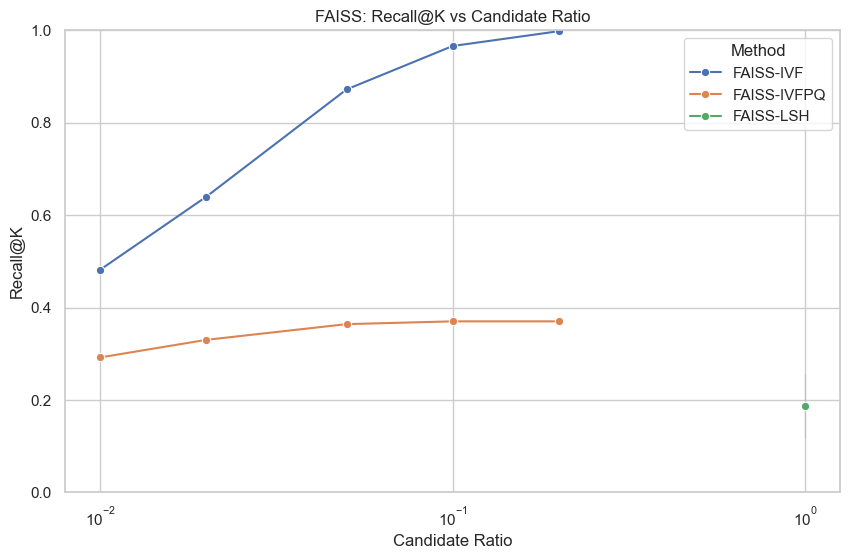

In [12]:
import seaborn as sns

sns.set(style="whitegrid")

# Plot Recall vs Candidate Ratio for Experiment 1
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_exp1, x="candidate_ratio", y="recall_at_k", hue="method", marker="o")
plt.title("FAISS: Recall@K vs Candidate Ratio")
plt.xlabel("Candidate Ratio")
plt.ylabel("Recall@K")
plt.xscale('log')
plt.ylim(0, 1)
plt.legend(title="Method")
plt.show()